[View in Colaboratory](https://colab.research.google.com/github/stanimman/Pneumonia-Detection/blob/master/Interesting_Work_Done.ipynb)

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

<h1>Welcome to Colaboratory!</h1>
Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. See our [FAQ](https://research.google.com/colaboratory/faq.html) for more info.

## Getting Started
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Loading and saving data: Local files, Drive, Sheets, Google Cloud Storage](/notebooks/io.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Using Google Cloud BigQuery](/notebooks/bigquery.ipynb)
- [Forms](/notebooks/forms.ipynb), [Charts](/notebooks/charts.ipynb), [Markdown](/notebooks/markdown_guide.ipynb), & [Widgets](/notebooks/widgets.ipynb)
- [TensorFlow with GPU](/notebooks/gpu.ipynb)
- [TensorFlow with TPU](/notebooks/tpu.ipynb)
- [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/): [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb) & [First Steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Using Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


## Highlighted Features
### Seedbank

Looking for Colab notebooks to learn from? Check out [Seedbank](https://tools.google.com/seedbank/), a place to discover interactive machine learning examples.

### TensorFlow execution

Colaboratory allows you to execute TensorFlow code in your browser with a single click. The example below adds two matrices.

$\begin{bmatrix}
  1. & 1. & 1. \\
  1. & 1. & 1. \\
\end{bmatrix} +
\begin{bmatrix}
  1. & 2. & 3. \\
  4. & 5. & 6. \\
\end{bmatrix} =
\begin{bmatrix}
  2. & 3. & 4. \\
  5. & 6. & 7. \\
\end{bmatrix}$

In [3]:
!pip uninstall Pillow -y

!pip install Pillow

Uninstalling Pillow-4.0.0:
  Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 6.1MB/s 


In [1]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [2]:
!pip install -q kaggle-cli
!kg download -u 'stanimman' -p 'Legspinner@1' -c 'rsna-pneumonia-detection-challenge'
!git clone https://github.com/stanimman/Pneumonia-Detection.git

/usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/GCP%20Credits%20Request%20Link%20-%20RSNA.txt

GCP%20Credits%20Request%20Link%20-%20RSNA.txt 100% |###| Time: 0:00:00 413.9 B/s

downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_1_detailed_class_info.csv

stage_1_detailed_class_info.csv 100% |###########

In [0]:
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images # Need to understand what is the various argument that is passed on

In [4]:
!ls

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_test_images.zip
Pneumonia-Detection			       stage_1_train_images
sample_data				       stage_1_train_images.zip
stage_1_detailed_class_info.csv		       stage_1_train_labels.csv
stage_1_sample_submission.csv


In [0]:
# install dependencies not included by Colab# insta 
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
#!pip3 install -q tqdm 
#!pip3 install -q imgaug

In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('Pneumonia-Detection/stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [8]:
!ls

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_test_images.zip
Pneumonia-Detection			       stage_1_train_images
sample_data				       stage_1_train_images.zip
stage_1_detailed_class_info.csv		       stage_1_train_labels.csv
stage_1_sample_submission.csv


In [9]:
# load and shuffle filenames
folder = 'stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:25088]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 22528
n valid samples 2560


Total train images: 25684
Images with pneumonia: 5659


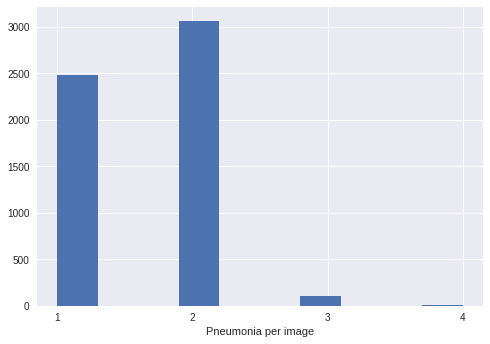

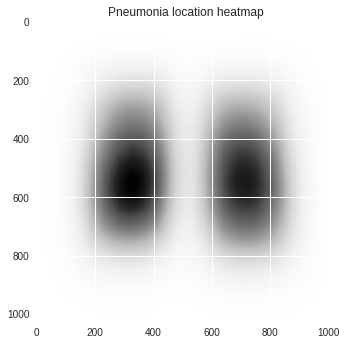

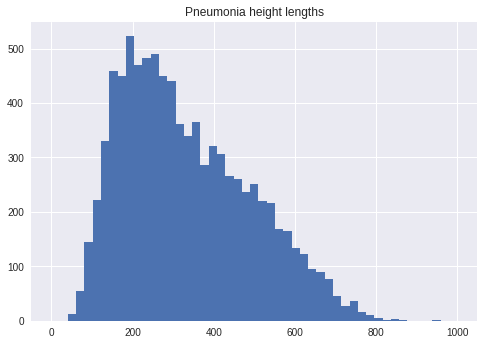

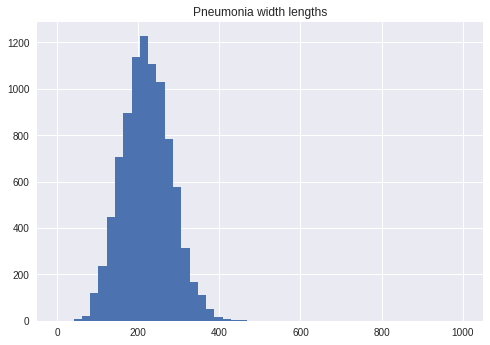

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [10]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:

def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256 * 256*1, activation='relu')(x)
    x = keras.layers.Reshape((256,256,1))(x)
    #x = Dropout(0.5)(x)
    #x = keras.layers.Dense(1024* 1024*1, activation="relu")(x)
    outputs = x
    #outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [15]:
model.output.shape

TensorShape([Dimension(None), Dimension(256), Dimension(256), Dimension(1)])

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))



In [0]:
#from tensorflow.keras import applications
#vgg_model = applications.

In [18]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(
    optimizer='adam',
    loss=iou_bce_loss,
    metrics=['accuracy',mean_iou]
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.5.155.138:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 112298177346739772)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9738185409876518667)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9388590986626929005)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7596200925130983308)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6489848163041325571)
INFO:tensorflow:*** Available Device: _DeviceAtt

In [0]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [0]:
# create train and validation generators
folder = 'stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=256, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=256, image_size=256, shuffle=False, predict=False)

In [21]:
tpu_model.fit_generator(
    train_gen,
    epochs=10,
    steps_per_epoch=100,
    validation_data=valid_gen,
    callbacks=[learning_rate]
)

Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train, [TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name='input_10'), TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name='reshape_target0')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Get updates: Tensor("loss/mul:0", shape=(), dtype=float32)
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 95.29789519309998 secs
INFO:tensorflow:Setting weights on TPU model.
 99/100 [============================>.] - ETA: 11s - loss: 0.5212 - acc: 0.9674 - mean_iou: 0.6600INFO:tensorflow:New input shapes; (re-)compiling: mode=eval, [TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name='input_10'), TensorSpec(shape=(32, 256, 256, 1), dtype=tf.fl

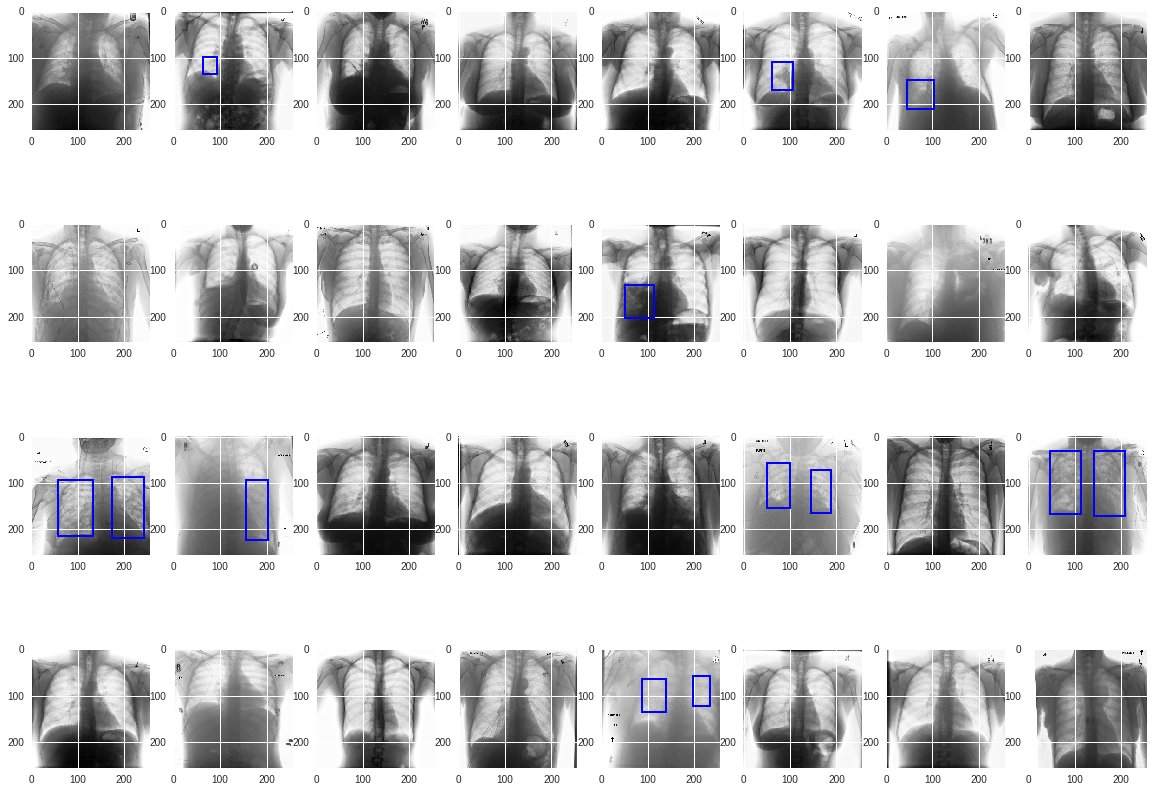

In [39]:
for imgs, msks in valid_gen:
    # predict batch of images
    imgs = imgs[0:32]
    msks = msks[0:32]
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        #print(msk.,pred)
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [0]:
comp = preds[0,:, :,0] > 0.5

In [44]:
np.unique(comp)

array([False])

In [0]:
# model.compile(optimizer='adam',
#               loss=iou_bce_loss,
#               metrics=['accuracy', mean_iou])

# # cosine learning rate annealing
# def cosine_annealing(x):
#     lr = 0.001
#     epochs = 25
#     return lr*(np.cos(np.pi*x/epochs)+1.)/2
# learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# # create train and validation generators
# folder = '../input/stage_1_train_images'
# train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
# valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

# history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

### GitHub

For a full discussion of interactions between Colab and GitHub, see [Using Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb). As a brief summary:

To save a copy of your Colab notebook to Github, select *File → Save a copy to GitHub…*

To load a specific notebook from github, append the github path to http://colab.research.google.com/github/.
For example to load this notebook in Colab: [https://github.com/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb) use the following Colab URL: [https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb)



### Visualization

Colaboratory includes widely used libraries like [matplotlib](https://matplotlib.org/), simplifying visualization.

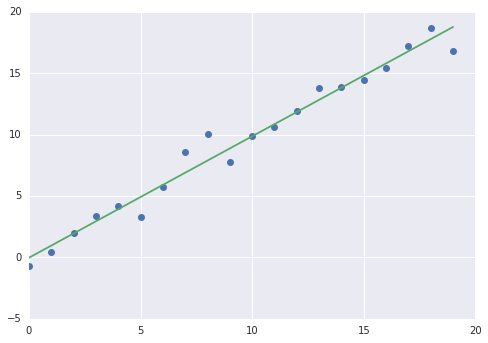

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(20)
y = [x_i + np.random.randn(1) for x_i in x]
a, b = np.polyfit(x, y, 1)
_ = plt.plot(x, y, 'o', np.arange(20), a*np.arange(20)+b, '-')

Want to use a new library?  `pip install` it at the top of the notebook. Then that library can be used anywhere else in the notebook. For recipes to import commonly used libraries, refer to the [importing libraries example notebook](/notebooks/snippets/importing_libraries.ipynb).

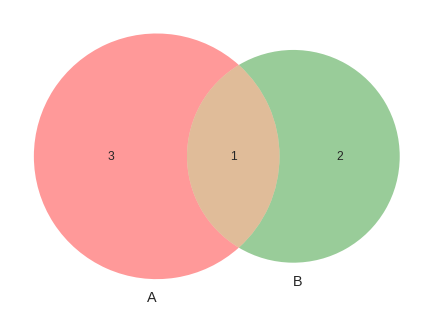

In [0]:
!pip install -q matplotlib-venn

from matplotlib_venn import venn2
_ = venn2(subsets = (3, 2, 1))

### Forms

Forms can be used to parameterize code. See the [forms example notebook](/notebooks/forms.ipynb) for more details.

In [0]:
#@title Examples

text = 'value' #@param 
date_input = '2018-03-22' #@param {type:"date"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]


### Local runtime support

Colab  supports connecting to a Jupyter runtime on your local machine. For more information, see our [documentation](https://research.google.com/colaboratory/local-runtimes.html).